# Lab 10: Fully Connected Neural Networks

In this assignment, we will learn fully connected neural network. 


## 1. Example

This assignement should be run on Google Colab where you can use free GPU to accelerate the computation. Please refer to our slides to set up GPU. 

### 1. Install Pytorch

In [ ]:
!pip install torch torchvision   # install pytorch

### 2. Check GPU

In [ ]:
!/opt/bin/nvidia-smi  #show GPU 

Mon Apr 11 13:17:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 3. Mount to google drive (optional)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### 4. Code

In [ ]:
#Import Libraries
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [ ]:
args={}
args['batch_size']=100
args['test_batch_size']=100
args['epochs']=10  #The number of Epochs is the number of times you go through the full dataset. 
args['lr']=0.01 #Learning rate is how fast it will decend. 
args['log_interval']=10

In [ ]:
# build an mlp
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(28*28, 512)   # linear layer (784 -> 256)
        self.fc2 = nn.Linear(512,384)  # linear layer (256 -> 128)
        self.fc3 = nn.Linear(384,256)  # linear layer (128 -> 10)
        self.fc4 = nn.Linear(256,192) 
        self.fc5 = nn.Linear(192,128)
        self.fc6 = nn.Linear(128,96)
        self.fc7 = nn.Linear(96,64)
        self.fc8 = nn.Linear(64,48)
        self.fc9 = nn.Linear(48,32)
        self.fc10 = nn.Linear(32,10)

    def forward(self, x):
        h0 = x.view(-1,28*28) #input layer
        h1 = F.relu(self.fc1(h0)) # hidden layer 1
        h2 = F.relu(self.fc2(h1)) # hidden layer 2
        h3 = F.relu(self.fc3(h2))
        h4 = F.relu(self.fc4(h3))
        h5 = F.relu(self.fc5(h4))
        h6 = F.relu(self.fc6(h5))
        h7 = F.relu(self.fc7(h6))
        h8 = F.relu(self.fc8(h7))
        h9 = F.relu(self.fc9(h8))
        h10 = self.fc10(h9) # output layer

        return h10

model = Net()
model.cuda() # put the model on GPU
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=384, bias=True)
  (fc3): Linear(in_features=384, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=192, bias=True)
  (fc5): Linear(in_features=192, out_features=128, bias=True)
  (fc6): Linear(in_features=128, out_features=96, bias=True)
  (fc7): Linear(in_features=96, out_features=64, bias=True)
  (fc8): Linear(in_features=64, out_features=48, bias=True)
  (fc9): Linear(in_features=48, out_features=32, bias=True)
  (fc10): Linear(in_features=32, out_features=10, bias=True)
)


In [ ]:
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(),lr = args['lr'])

In [ ]:
#load the data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['batch_size'], shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], shuffle=False)

In [ ]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        
        output = model(data)
        loss = criterion(output, target)
        train_losses.append(loss.cpu().detach().numpy())

        # compute gradients
        optimizer.zero_grad()
        loss.backward()

        #to do a one-step update on our parameter.
        optimizer.step()

        #Print out the loss periodically. 
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [ ]:
def test():
    model.eval() #do not update parameters anymore
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()

        output = model(data)
        test_loss += criterion(output, target).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] 
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))


In [ ]:
train_losses = []
test_acc = []
for epoch in range(1, args['epochs'] + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.317095
Train Epoch: 1 [1000/60000 (2%)]	Loss: 2.315265
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.309807
Train Epoch: 1 [3000/60000 (5%)]	Loss: 2.311781
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.302321
Train Epoch: 1 [5000/60000 (8%)]	Loss: 2.300478
Train Epoch: 1 [6000/60000 (10%)]	Loss: 2.299820
Train Epoch: 1 [7000/60000 (12%)]	Loss: 2.285893
Train Epoch: 1 [8000/60000 (13%)]	Loss: 2.306749
Train Epoch: 1 [9000/60000 (15%)]	Loss: 2.309285
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.314142
Train Epoch: 1 [11000/60000 (18%)]	Loss: 2.298471
Train Epoch: 1 [12000/60000 (20%)]	Loss: 2.296202
Train Epoch: 1 [13000/60000 (22%)]	Loss: 2.311513
Train Epoch: 1 [14000/60000 (23%)]	Loss: 2.314825
Train Epoch: 1 [15000/60000 (25%)]	Loss: 2.311329
Train Epoch: 1 [16000/60000 (27%)]	Loss: 2.314108
Train Epoch: 1 [17000/60000 (28%)]	Loss: 2.299969
Train Epoch: 1 [18000/60000 (30%)]	Loss: 2.296268
Train Epoch: 1 [19000/60000 (32%)]	Loss: 2.318977
Train Epoch: 1 [200

## 2. Tasks

### 1. Please use other activation functions, e.g., sigmoid, tanh, and then plot the training loss and testing accuracy. 

When plotting the training loss, the x-axis is iteration and the y-axis is training loss. When plotting the testing accuracy,  the x-axis is epoch and the y-axis is the testing accuracy.

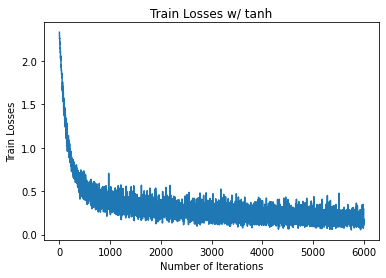

In [ ]:
# your code
import matplotlib.pyplot as plt

plt.plot(train_losses)
plt.xlabel('Number of Iterations')
plt.ylabel('Train Losses')
plt.title('Train Losses w/ tanh')
plt.show()

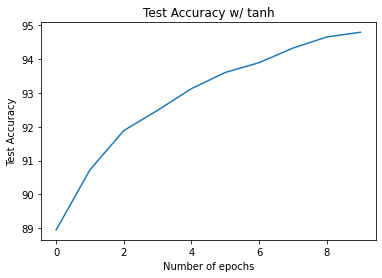

In [ ]:
plt.plot(test_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy w/ tanh')
plt.show()

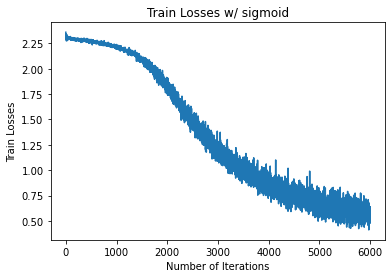

In [ ]:
plt.plot(train_losses)
plt.xlabel('Number of Iterations')
plt.ylabel('Train Losses')
plt.title('Train Losses w/ sigmoid')
plt.show()

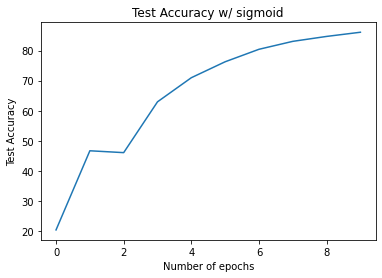

In [ ]:
plt.plot(test_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy w/ sigmoid')
plt.show()

### 2. Please use different layers in the model, e.g., 1 layer, 5 layers, 10 layers,  and then plot the training loss and testing accuracy.

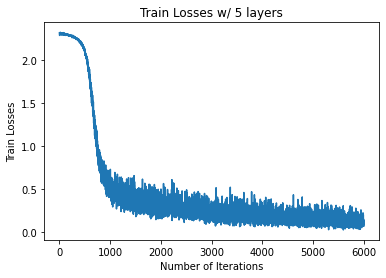

In [ ]:
# your code
plt.plot(train_losses)
plt.xlabel('Number of Iterations')
plt.ylabel('Train Losses')
plt.title('Train Losses w/ 5 layers')
plt.show()

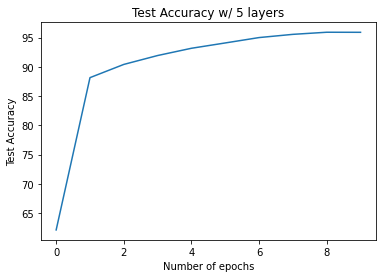

In [ ]:
plt.plot(test_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy w/ 5 layers')
plt.show()

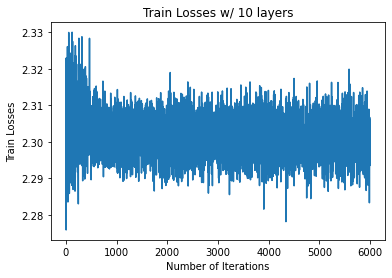

In [ ]:
plt.plot(train_losses)
plt.xlabel('Number of Iterations')
plt.ylabel('Train Losses')
plt.title('Train Losses w/ 10 layers')
plt.show()

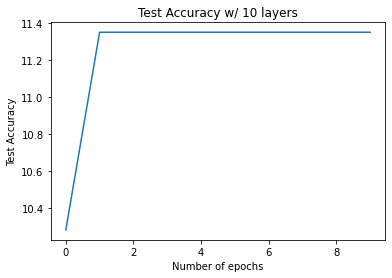

In [ ]:
plt.plot(test_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy w/ 10 layers')
plt.show()